Calcula las intensidades de las imágenes el momento antes de entrar a la red

In [1]:
import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import SimpleITK as sitk # para calcular rangos
import numpy as np
import io
from PIL import Image
import random
import sys
import pandas as pd
import math

In [2]:
sys.path.append("/Users/hugom/PET-IA/src")

In [3]:
from datasets import ADNIDataset, FleniMyriamDataset, BaseDataset
from transforms import TransformGridImage, ToLabelOutputConfigurable
import torch
import torchvision
from torchvision import transforms, utils, models, datasets

In [4]:
def calculateMeanAndStd(dataloader):
    sum = 0.0
    count = 0
    analyzedImages = 0
    for inputs, labels in dataloader:
        array = inputs[0].flatten() # batch size = 1
    
        sum += array.sum()
        count += array.shape[0] 
        
        analyzedImages += 1
    
    mean = sum / count
    
    sum2 = 0.0
    for inputs, labels in dataloader:
        array = inputs[0].flatten() # batch size = 1
    
        sum2 += torch.square(array - mean).sum()
        
    std = math.sqrt(sum2 / count)
    
    return mean.item(), std, analyzedImages

# Intensidades ADNI Preproc 3

In [5]:
def getAllImageIds():
    ids = []
    paths = list(Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'))
    for path in paths:
        ids.append(os.path.split(os.path.split(path)[0])[1])
    return ids

In [6]:
def logDebug(str):
    True # ignore

Cálculo de medias y stds

In [7]:
# Puedo calcularlo sobre todas las imágenes:
df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter
# O sólo sobre un train set: (para calcular mean y std)
# trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_MCI,AD_dxvisit_train.csv"
# csv = pd.read_csv(trainSet)

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor()
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [9]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: 0.2610228657722473
Std: 0.4634732792445042


Construyo un dataframe que tenga esos images

In [10]:
means = [mean, mean, mean]
stds = [std, std, std]

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

Maximo: 5.443622589111328
Mínimo: -0.5631886124610901
Excluded: 0 0.0%
Total: 3761


Text(0.5, 1.0, 'ADNI Values (100 muestras)')

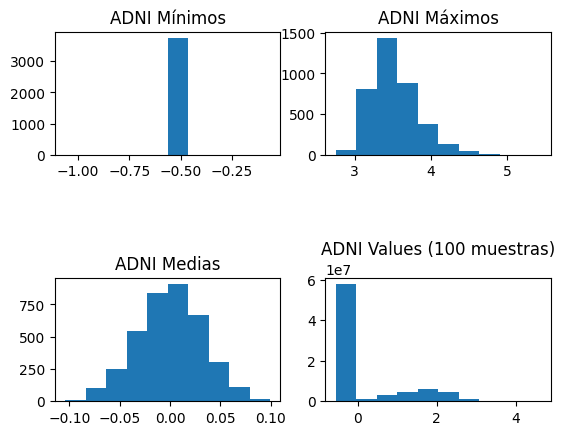

In [11]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

# title = "ADNI preprocessed3"
title = "ADNI"

ax1.hist(mins, bins=10)
ax1.set_title(f"{title} Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title(f"{title} Máximos")

ax3.hist(means, bins=10)
ax3.set_title(f"{title} Medias")

ax4.hist(values, bins=10)
ax4.set_title(f"{title} Values (" + str(valuesConsidered) + " muestras)")

# Intensidades Fleni100

In [12]:
fleniValDatasetCSV = "/Users/hugom/PET-IA/Sets/fleni-myriam-curated.csv"
fleniImagesFolder = "/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3"
df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter
fleniTransforms = torchvision.transforms.Compose([
    TransformGridImage({}),
    torchvision.transforms.ToTensor()
])
dataset = FleniMyriamDataset('fleni', fleniValDatasetCSV, fleniImagesFolder, transform = fleniTransforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [13]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Count: " + str(count))

Mean: 3383.63818359375
Std: 7348.98169816744
Count: 100


In [14]:
means = [mean, mean, mean]
stds = [std, std, std]
dataAugmentation = {}
fleniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
fleniDataset = FleniMyriamDataset('fleni', '/Users/hugom/PET-IA/Sets/fleni-myriam-curated.csv', '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3', transform = fleniTransforms)
fleniDataloader = torch.utils.data.DataLoader(fleniDataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 100
Maximo: 12.266182899475098
Mínimo: -0.46042272448539734


Text(0.5, 1.0, 'Fleni100 Values')

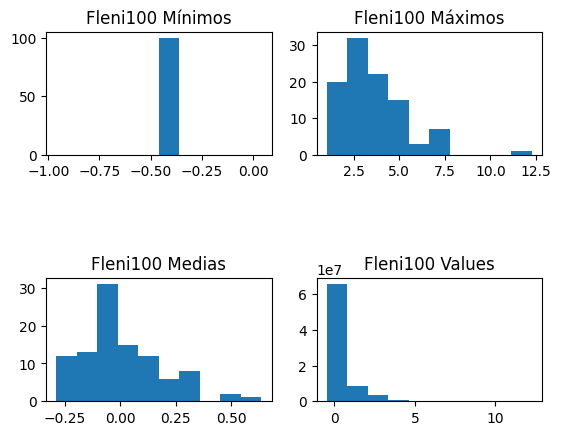

In [15]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in fleniDataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

title = "Fleni100"

ax1.hist(mins, bins=10)
ax1.set_title(f"{title} Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title(f"{title} Máximos")

ax3.hist(means, bins=10)
ax3.set_title(f"{title} Medias")

ax4.hist(values, bins=10)
ax4.set_title(f"{title} Values")

# Intensidades EBRAINS

In [16]:
csvFile = '/Users/hugom/PET-IA/Sets/ebrains.csv'
imagesFolder = '/Users/hugom/PET-IA/Full-DBs/ebrains/data_nifti_stripped/hc_images_preprocessed'
dataAugmentation = {}
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor()
])
dataset = BaseDataset('ebrains', csvFile, imagesFolder, studyIDLabel = 'ID', transform = ebrainsTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [17]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hugom/PET-IA/Full-DBs/ebrains/data_nifti_stripped/hc_images_preprocessed/s0042855A-207260-00001-000001/metadata.json'

In [ ]:
means = [mean, mean, mean]
stds = [std, std, std]
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dataset = BaseDataset('ebrains', csvFile, imagesFolder, studyIDLabel = 'ID', transform = ebrainsTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = 0
total = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        excluded += 1
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(excluded) + " " + str(excluded * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("EBRAINS Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("EBRAINS Máximos")

ax3.hist(means, bins=10)
ax3.set_title("EBRAINS Medias")

ax4.hist(values, bins=10)
ax4.set_title("EBRAINS Values (" + str(valuesConsidered) + " muestras)")

# Intensidades Chinese

In [18]:
csvFile = '/Users/hugom/PET-IA/Sets/chinese.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/chinese-preprocessed'
means = [mean, mean, mean]
stds = [std, std, std]
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "CN": 0
}
dataset = BaseDataset('chinese', csvFile, imagesFolder, studyIDLabel = 'SubjectID', transform = ebrainsTransforms, truthLabel = 'Diagnosis')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [19]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print(f"Count: {count}")

Mean: 0.19838069379329681
Std: 0.40906781690739724
Count: 116


In [20]:
means = [mean, mean, mean]
stds = [std, std, std]
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dicti = {
    "AD": 1,
    "CN": 0
}
dataset = BaseDataset('chinese', csvFile, imagesFolder, studyIDLabel = 'SubjectID', transform = ebrainsTransforms, truthLabel = 'Diagnosis')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Maximo: 5.4196248054504395
Mínimo: -0.4849579632282257
Excluded: 0 0.0%
Total: 116


Text(0.5, 1.0, 'Chinese Values (100 muestras)')

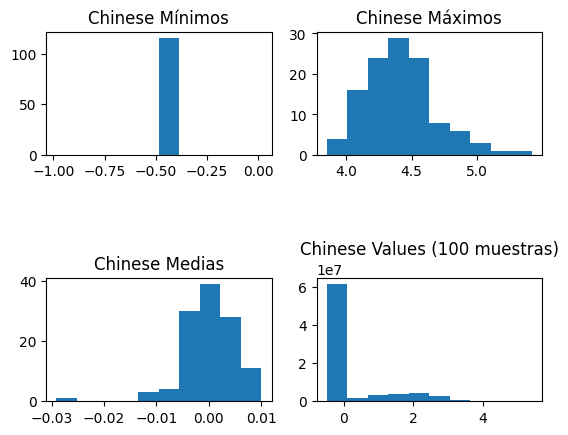

In [21]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = 0
total = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        excluded += 1
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(excluded) + " " + str(excluded * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("Chinese Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Chinese Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Chinese Medias")

ax4.hist(values, bins=10)
ax4.set_title("Chinese Values (" + str(valuesConsidered) + " muestras)")

# Fleni60

In [22]:
csvFile = '/Users/hugom/PET-IA/Sets/fleni-PET_clasificados60.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni60', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Conclusion PET')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [23]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

Mean: 3864.730224609375
Std: 8282.332521699427
Analyzed: 60


In [24]:
csvFile = '/Users/hugom/PET-IA/Sets/fleni-PET_clasificados60.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni60', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Conclusion PET')
fleniDataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 60
Maximo: 8.08200740814209
Mínimo: -0.46662336587905884


Text(0.5, 1.0, 'Fleni60 Values')

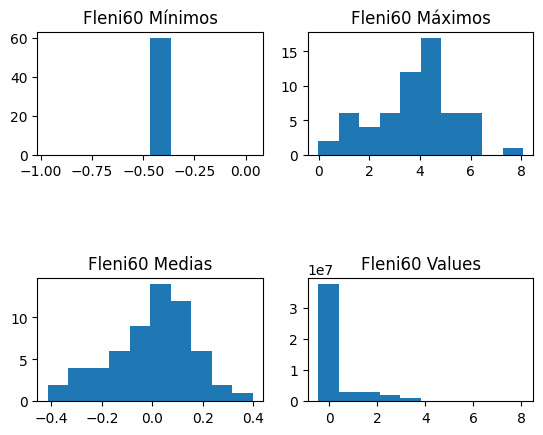

In [25]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in fleniDataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

title = "Fleni60"

ax1.hist(mins, bins=10)
ax1.set_title(f"{title} Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title(f"{title} Máximos")

ax3.hist(means, bins=10)
ax3.set_title(f"{title} Medias")

ax4.hist(values, bins=10)
ax4.set_title(f"{title} Values")

# Fleni600

In [10]:
csvFile = '/Users/hugom/PET-IA/Sets/fleni600_limpio.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni600', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Diagnóstico')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [11]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

Mean: 3744.19775390625
Std: 8106.346155944736
Analyzed: 629


In [12]:
csvFile = '/Users/hugom/PET-IA/Sets/fleni600_limpio.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed4'
ebrainsTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
dataset = BaseDataset('fleni600', csvFile, imagesFolder, studyIDLabel = 'anon_id', transform = ebrainsTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Diagnóstico')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 629
Maximo: 11.675737380981445
Mínimo: -0.4618847668170929


Text(0.5, 1.0, 'Fleni600 Values')

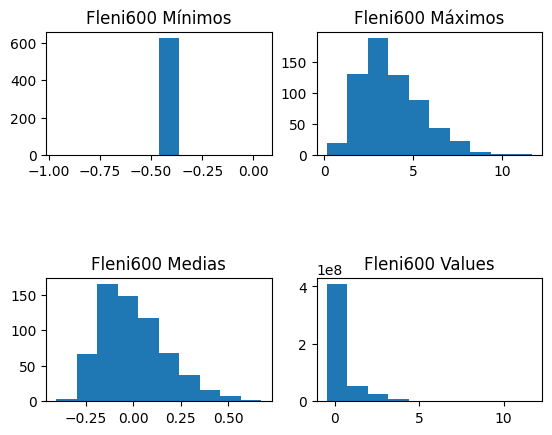

In [13]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

title = "Fleni600"

ax1.hist(mins, bins=10)
ax1.set_title(f"{title} Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title(f"{title} Máximos")

ax3.hist(means, bins=10)
ax3.set_title(f"{title} Medias")

ax4.hist(values, bins=10)
ax4.set_title(f"{title} Values")

# Mérida

In [26]:
tsvFile = '/Users/hugom/PET-IA/Full-DBs/ines-merida-db/pool/DM/TEP/CERMEP_MXFDG/BASE/DATABASE_SENT/ALL/participants.tsv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/merida-preprocessed'
meridaTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "non-AD": 0
}
csv = pd.read_table(tsvFile, index_col = False)
csv['Group'] = 'non-AD'
dataset = BaseDataset('merida', csv, imagesFolder, studyIDLabel = 'participant_id', transform = meridaTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [27]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

Mean: 2300.842041015625
Std: 4192.4441558594435
Analyzed: 37


In [28]:
meridaTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dataset = BaseDataset('merida', csv, imagesFolder, studyIDLabel = 'participant_id', transform = meridaTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 37
Maximo: 5.379516124725342
Mínimo: -0.5488068461418152


Text(0.5, 1.0, 'Mérida Values')

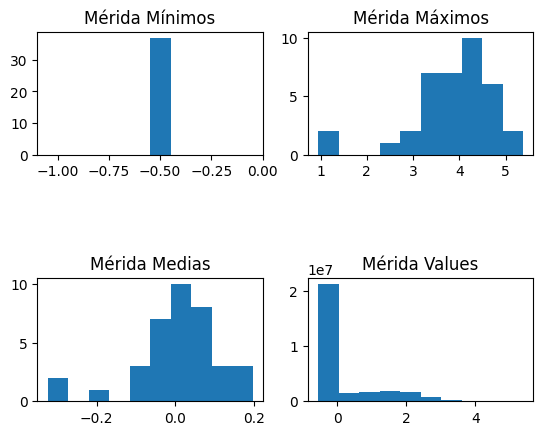

In [29]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Mérida Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Mérida Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Mérida Medias")

ax4.hist(values, bins=10)
ax4.set_title("Mérida Values")

# Oasis 3

In [30]:
csvFile = '/Users/hugom/PET-IA/Sets/oasis3.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/oasis3-preprocessed'
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [31]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

Mean: 3357.1865234375
Std: 7021.012177741896
Analyzed: 126


In [32]:
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 126
Maximo: 6.5014119148254395
Mínimo: -0.4781627655029297


Text(0.5, 1.0, 'Oasis3 Values')

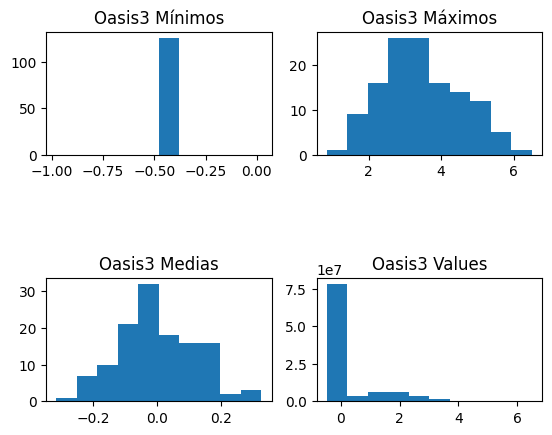

In [33]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Oasis3 Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Oasis3 Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Oasis3 Medias")

ax4.hist(values, bins=10)
ax4.set_title("Oasis3 Values")

# Oasis 3 (unsmoothed)

In [34]:
csvFile = '/Users/hugom/PET-IA/Sets/oasis3.csv'
imagesFolder = '/Users/hugom/Tesis/Imagenes/oasis3-preprocessed-unsmoothed'
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor()
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

In [35]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))
print("Analyzed: " + str(count))

Mean: 3574.517578125
Std: 7557.575801803116
Analyzed: 126


In [36]:
oasisTransforms = torchvision.transforms.Compose([
    TransformGridImage(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([mean, mean, mean], [std, std, std])
])
dicti = {
    "AD": 1,
    "CN": 0
}
csv = pd.read_csv(csvFile)
csv['Group'] = 'CN'
dataset = BaseDataset('oasis3', csv, imagesFolder, studyIDLabel = 'StudyID', transform = oasisTransforms, target_transform = ToLabelOutputConfigurable(dicti), truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

Analizados: 126
Maximo: 9.69080638885498
Mínimo: -0.47297146916389465


Text(0.5, 1.0, 'Oasis3 Values')

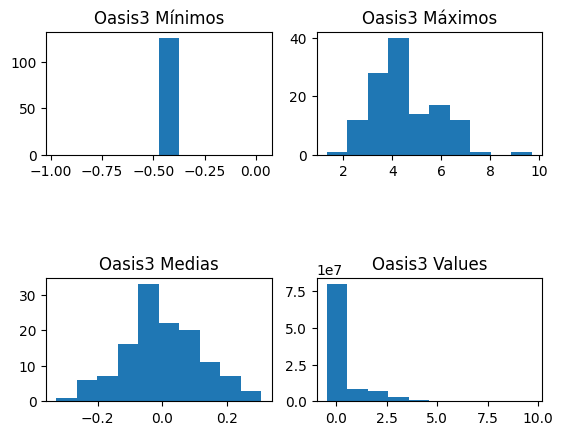

In [37]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Oasis3 Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Oasis3 Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Oasis3 Medias")

ax4.hist(values, bins=10)
ax4.set_title("Oasis3 Values")

# ADNI preproc continuous

In [38]:
# Puedo calcularlo sobre todas las imágenes:
df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter
# O sólo sobre un train set: (para calcular mean y std)
# trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_MCI,AD_dxvisit_train.csv"
# csv = pd.read_csv(trainSet)

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor()
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-continuous', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [39]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: 0.19176986813545227
Std: 0.4115589497673059


In [40]:
means = [mean, mean, mean]
stds = [std, std, std]

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-continuous', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI preprocessed3-cont Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI preprocessed3-cont Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI preprocessed3-cont Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI preprocessed3-cont Values (" + str(valuesConsidered) + " muestras)")

# ADNI preproc linear

In [ ]:
# Puedo calcularlo sobre todas las imágenes:
df = pd.DataFrame(getAllImageIds(), columns = ["ImageDataID"])
df['Group'] = 'AD' # Fake, it doesn't matter
# O sólo sobre un train set: (para calcular mean y std)
# trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_MCI,AD_dxvisit_train.csv"
# csv = pd.read_csv(trainSet)

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor()
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-linear', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
mean, std, count = calculateMeanAndStd(dataloader)
print("Mean: " + str(mean))
print("Std: " + str(std))

In [ ]:
means = [mean, mean, mean]
stds = [std, std, std]

dataAugmentation = {}
adniTransforms = torchvision.transforms.Compose([
    TransformGridImage(**dataAugmentation),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(means, stds)
])
dataset = ADNIDataset('adni', df, '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed-linear', indexOffset = 0, transform = adniTransforms, truthLabel = 'Group')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [ ]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0

for inputs, labels in dataloader:
    tensor = inputs[0] # batch size = 1
    
    
    img = sitk.GetImageFromArray(tensor.numpy())
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI preprocessed3-linear Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI preprocessed3-linear Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI preprocessed3-linear Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI preprocessed3-linear Values (" + str(valuesConsidered) + " muestras)")

# Testeo transformación no lineal

In [ ]:
try:  # SciPy >= 0.19
    from scipy.special import comb
except ImportError:
    from scipy.misc import comb
    
def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.
       Control points should be a list of lists, or list of tuples
       such as [ [1,1],
                 [2,3],
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000
        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([bernstein_poly(i, nPoints - 1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals


def nonlinear_transformation(x, prob=0.5):
    # necesario porque el algoritmo de abajo solo funciona con [0, 1]
    min = x.min()
    max = x.max()
    
    # traducimos a [0,1]
    
    x = (x - x.min()) / (x.max() - x.min()) # lo pasa a [0,1]
    
    # if random.random() >= prob:
    #     return x
    points = [[0, 0], [random.random(), random.random()], [random.random(), random.random()], [1, 1]]
    xpoints = [p[0] for p in points]
    ypoints = [p[1] for p in points]
    xvals, yvals = bezier_curve(points, nTimes=100000)  # (100000,)
    if random.random() < 0.5:
        # Half change to get flip
        xvals = np.sort(xvals)
    else:
        xvals, yvals = np.sort(xvals), np.sort(yvals)
    nonlinear_x = np.interp(x, xvals, yvals)

    # print('x[0,100,102,104]', x[0, 100, 102, 104])
    # print('nonlinear_x[0,100,102,104]', nonlinear_x[0, 100, 102, 104])
    
    # Restauro los valores
    nonlinear_x = nonlinear_x * (max - min)  + min

    return nonlinear_x


In [ ]:
a = np.array([1, 4, 3, 24, 234, 21, 3, 1, -10])
b = np.array([a.copy(), a.copy()])

nonlinear_transformation(b)